# Homework 3

### This is the solution of:
* Student1
* Student2
* Student3


The same general rules as for Homework 1 applies.

$$\newcommand{\dx}{\,\mathrm{d}x}
\newcommand{\ldb}{\left\llbracket}
\newcommand{\rdb}{\right\rrbracket}
\newcommand{\lp}{\left(}
\newcommand{\rp}{\right)}
\newcommand{\tn}{|\mspace{-1mu}|\mspace{-1mu}|}
\newcommand{\IR}{\mathbb{R}}
$$

## Problem 1 ($L^2$-projection)


Let $0 = x_0 < x_1 < x_2 < \ldots < x_{N} = 1$ be a partition of the interval
$I = (0,1)$ into $N$ subintervals of equal length $h=1/N$.  Moreover,
let $\{ \lambda_j\}_{j=0}^{N}$ be the set of nodal/hat basis functions of $V_h$
associated with the $N+1$ nodes $x_j$, $j = 0,1\ldots, N$, such that
The $L^2$-projection reads: find $P_hf\in V_h$ such that
$$
    \int_I(f - P_h f) v \dx = 0 \qquad\text{for all }v\in V_h
$$
We consider three different functions
* $f_1(x)=x\sin (3\pi x)$
* $f_2(x)=2-10x$
* $f_3(x)=x(1-x)$

**a)** Write a script ${\texttt {AssembleMassMatrix1D(x)}}$ that computes the mass matrix. 

**b)** Write a corresponding function $\texttt{AssembleLoadVector(x,f)}$ which computes 
the load vector for a given function $f$. Make sure that you can easily switch (for example by adding another input variable) out the quadrature
rule (Trapezoid and Simpson) to approximate the integrals $\int_{I} f \varphi_i \dx$

Convince yourself that your code is correct by computing the $L^2$ projection of the given functions, and observe that they look similar to the original function when plotting in the same figure (with enough mesh points). You do not need to document this.

**c)** Write a function $\texttt{ComputeErrorL2(x,Pf,f)}$ which computes the error in $L^2$ norm, 
$$\|P_h f-f \|=\sqrt{\int_0^1(P_h f-f)^2 dx}.$$
Hint: use the equivalent formula
$$\|P_h f-f \|=\sqrt{\sum_{i=1}^{N} \int_{x_{i-1}}^{x_{i}}(P_h f-f)^2 dx},$$
and approximate the integrals in each subinterval using Simpson's rule.

**d)** Test your code by computing the $L^2$-projection $P_h f\in V_h$ for the three given functions by using the
Trapezoidal rule to compute the load vector. Test with different $N$ values. Do the errors converge as expected? Why?

**e)** Repeat **d)** using Simpson's rule to compute the load vector. What do you find and why?

### Code Snippets

In [38]:
# Array and stuff 
import numpy as np
# Linear algebra solvers from scipy
import scipy.linalg as la
# Basic plotting routines from the matplotlib library 
import matplotlib.pyplot as plt
# We also need access to the colormaps for 3D plotting
from matplotlib import cm

def AssembleMassMatrix1D(x):
    # Number of intervals
    N = x.size-1
    # 1) Allocate and initiate matrix
    M = np.zeros((N+1,N+1))

    # 2) Compute volume contributions by iterating over 
    #    intervals I_0 to I_(N-1):
    for i in range(0,N):
        # Mesh  size
        h = (x[i+1]-x[i])
        # Compute local mass matrix
        M_loc = (h/6)*np.array([[2, 1],[1, 2]])
        # Write local matrix into global
        M[i, i] += M_loc[0, 0]
        # Add three more matrix entries
        #Tor and IssP: See slide 36 lecture 4-5
        M[i,i+1] += M_loc[0,1]
        M[i+1,i] += M_loc[1,0]
        M[i+1,i+1] += M_loc[1,1]
    return M

In [12]:
##TEST CELL######

# Array and stuff 
import numpy as np
# Linear algebra solvers from scipy
import scipy.linalg as la
# Basic plotting routines from the matplotlib library 
import matplotlib.pyplot as plt
# We also need access to the colormaps for 3D plotting
from matplotlib import cm

x = np.array([0, 1, 3, 4, 5])
M = AssembleMassMatrix1D(x)
print(M)

[[0.08333333 0.04166667 0.         0.         0.        ]
 [0.04166667 0.25       0.08333333 0.         0.        ]
 [0.         0.08333333 0.25       0.04166667 0.        ]
 [0.         0.         0.04166667 0.16666667 0.04166667]
 [0.         0.         0.         0.04166667 0.08333333]]


In [39]:
def AssembleLoadVector1D(x, f, quad):
    # Number of intervals
    N = x.size-1
    # 1) Allocate and initiate global load vector
    b = np.zeros(N+1)
    # 2) Compute volume contributions by iterating over intervals 
    #    I_1 to I_N:
    for i in range(1,N+1):
        # Mesh  size
        h = (x[i]-x[i-1])
        # Element load vector
        b_loc = np.zeros(2)
        # Apply quadrature rule to int f phi_{i-1} and int f phi_{i}
        # Trapezoidal
        if quad == 't':
            b_loc[0] = f(x[i-1])*h/2
            b_loc[1] = f(x[i])*h/2
        # Simpson
        elif quad == 's':
            m = (x[i]+x[i-1])/2
            b_loc[0] = h/6*(f(x[i-1])+2*f(m))
            b_loc[1] = h/6*(f(x[i])+2*f(m))
        
        # Add to global vector
        b[i-1] += b_loc[0]
        b[i] += b_loc[1]

    return b

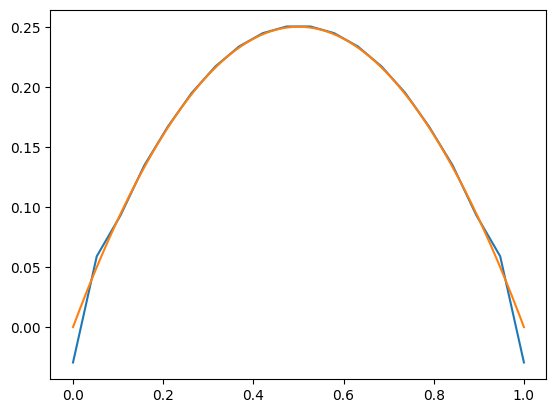

In [65]:
#Task 1b) (behöver ej dokumenteras)

f = lambda x : x*(1 - x)
N = 20
x = np.linspace(0,1,N)
x_anal = np.linspace(0,1,999)
M = AssembleMassMatrix1D(x)
b = AssembleLoadVector1D(x,f,'t') 
eps = la.solve(M,b)
#print(eps)
plt.plot(x,eps)
plt.plot(x_anal,f(x_anal))



In [57]:
def ComputeErrorL2(x,Pf,f):
    # Pf is an arracy consisting of the L2 projection evaluated on the mesh points
    # f is a function for f1, f2 or f3
    N = Pf.size-1
    err = 0
    for i in range(N):
        h = x[i+1]-x[i] 
        Pfl = Pf[i] # L2 projection value at x[i]
        Pfr = Pf[i+1] # L2 projection value at x[i+1]
        fl =  f(x[i]) #function value at x[i]
        fr = f(x[i+1]) # function value at x[i+1]
        m = (x[i]+x[i+1])/2
        Pfm = (Pfl+Pfr)*0.5 #Maybe? This is my own idea
        err = err+ ((Pfl-fl)**2+(Pfr-fr)**2+4*(Pfm-f(m))**2)*h/6 # Simpsons rule
        #print(err)
    return np.sqrt(err) # hint: ... is not just err

In [60]:

def CalcProjectionL2(x,f,quad):
    M = AssembleMassMatrix1D(x)
    b = AssembleLoadVector1D(x,f,quad)
    eps = la.solve(M,b)
    return eps

In [66]:
#TASK 1d) and e)

# Functions
f1 = lambda x : x*np.sin(3*np.pi*x)
f2 = lambda x : 2 - 10*x
f3 = lambda x : x*(1 - x)
funs = [f1,f2,f3]
error = np.zeros((4,3))
N_arr = [8, 16, 32, 64]

for i in range(0,len(N_arr)):
    x = np.linspace(0,1,N_arr[i])
    for j in range(0,len(funs)):
        eps = CalcProjectionL2(x,funs[j],'s')
        error[i,j] = ComputeErrorL2(x, eps, funs[j])
        
print(error)

[[5.18228659e-02 7.12950747e-16 2.40512511e-03]
 [1.05836228e-02 6.41212288e-16 5.23782801e-04]
 [2.43536757e-03 7.85320526e-16 1.22633850e-04]
 [5.87105396e-04 6.08792160e-16 2.96929025e-05]]


## Problem 2  (The variational/weak formulation of Poisson's equation)

Note: Problem 2 is a theoretical exercise. You are not required to write any programming code.

**a)**
Derive the weak formulation for the steady-state advection-diffusion equation with variable coefficents, 
\begin{align*}
- (a(x)u(x)')' + c(x)u(x) = f \quad \text{in } I = (0,1)
\\
u(0) = 0, \quad u'(1) = 10,
\end{align*}
for two smooth functions $a(x)$ and $c(x)$ satisfying $a(x) \geqslant a_0 > 0$
and $c(x) \geqslant 0$.

**b)**
Derive a finite element method in suitable function spaces. 

**c)**
Derive the linear system for the above finite element method. 

## Problem 3 (A 1D Finite Element Solver)

**a**) For $u(x) = x + \cos(2\pi x)$, compute a right-hand side $f$ and boundary values $g_R$, $g_N$
such that $u(x)$ solves the two-point boundary value problem on $I = [0,1]$ given by
\begin{gather}
-u''= f, \quad 0<x<1, 
\\
u'(0)=-g_N, \quad u'(1)= (g_R - u(1))
\end{gather}
a Neumann boundary condition on the left end point and a Robin boundary condition on the right end point.

**b)** Write down the weak form and then the finite element method, and be precise with the function spaces. Implement a finite element solver for this two-point boundary problem. 
Use uniform meshes with $h=1/N$ for $N = 4, 8, 16, 32, 64, 128$ and
compare the numerical solution $u_h$ with the exact solution $u(x)$
by plotting $u_h$ for $N = 4, 8, 16, 128$ and $u$ into the same figure.

**c)** Define the energy norm $\tn v \tn$ for $v \in V$ for this problem. Assuming that you can integrate the
right hand side $\int_I f v_h$ **exactly** for $v \in V_h \subset V$, show that the energy error satisfies
\begin{align*} 
 \tn u-u_h\tn^2=\tn u\tn^2-\tn u_h\tn^2     \quad\quad\quad\quad\quad\quad(1)
\end{align*}
by exploiting the Galerkin orthogonality. Hint: there is a similar identity in the lecture notes. You may follow the same procedure for the proof, but note that the energy norm here has a different expression.

Next, show that the following identity holds: 
\begin{align*}
\tn u_h\tn^2 =  U^T A U              \quad\quad\quad\quad\quad\quad\quad\quad\quad\quad (2)
\end{align*}
where $U$ is the  coefficient vector corresponding to $u_h = \sum_{i=0}^{N} U_i \varphi_i$ and $A$ is the stiffness matrix for the problem at hand (including the contribution from the boundary).

**d)** For the given $N$ in b), compute the errors in the follwoing norms

* a) The maximum norm 
* b) The energy norm  

present the results in log-log plots (error versus $h$) and specify the convergence rate. Do they converge as expected?

Hint: use (1) to compute the error in the energy norm (be careful with the squares). For the first term in the right-hand side of (1), you can use a composite quadrature. For the second term in the right-hand side of (1), you can use the formula given in (2). 

Hint: (1) only holds if the load vector is computed exactly. When you approximate the integrals in the load vector, use a very accurate quadrature. 


### Code Snippets

In [ ]:
def AssembleStiffnessMatrix1D(x):
    # Number of intervals
    N = x.size-1
    # 1) Allocate and initiate matrix
    A = ...

    # 2) Compute volume contributions by iterating over 
    #    intervals I_0 to I_(N-1):
    for i in range(0,N):
        # Mesh  size
        h = ...
        # Compute local stiffness matrix
        A_loc = ...*np.array([[1, -1],[-1, 1]])
        # Write local matrix into global
        A[i, i] += A_loc[0, 0]
        # Add three more matrix entries
        ...
        ...
        ...
    
    # 3) Compute natural boundary contributions
    # Add Robin on the right
    A[N, N] += ...
    
    return A

In [ ]:
def AssembleLoadVector1D(x, f, g_N, g_R):
    # Number of intervals
    N = ...
    # 1) Allocate and initiate global load vector
    b = ...
    # 2) Compute volume contributions by iterating over intervals 
    #    I_0 to I_(N-1):
    for i in range(0,N):
        # Use the code from the AssembleLoadVector1D used in the L2-projection
        ...

    # 3) Incorporate boundary values e.g
    # Neumann
    b[0] += g_N(0)

    # Robin
    b[N] += ...

    return b